In [ ]:
!pip install kaggle pretty_midi torch torchvision torchaudio scikit-learn matplotlib tqdm > /dev/null

from google.colab import drive
drive.mount('/content/drive')

import os, re, json, glob, zipfile, random, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# 1) Konfigurasi path & unduh ZIP
# -------------------------
FILE_ID = "1VPx3nKsEPR-GV9v0QiNZRbA_Ptdt7lsA"   # ID ZIP gabungan (punyamu)
ZIP_PATH = Path("/content/dataset_mirex.zip")
EXTRACT_DIR = Path("/content/dataset_mirex")    # root ekstraksi

SAVE_DIR = Path("/content/drive/MyDrive/dataset_mirex/miditrainX")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

import gdown
if not ZIP_PATH.exists():
    print("Downloading ZIP via gdown...")
    gdown.download(id=FILE_ID, output=str(ZIP_PATH), quiet=False)
else:
    print("ZIP already exists:", ZIP_PATH)

print("Extracting ZIP ...")
EXTRACT_DIR.mkdir(parents=True, exist_ok=True)
with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    zf.extractall(EXTRACT_DIR)

print("Done extract.")
print("EXTRACT_DIR content:")
for p in EXTRACT_DIR.iterdir():
    print(" -", p)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ZIP already exists: /content/dataset_mirex.zip
Extracting ZIP ...
Done extract.
EXTRACT_DIR content:
 - /content/dataset_mirex/dataset
 - /content/dataset_mirex/README.txt


In [ ]:
from pathlib import Path
import os

EXTRACT_DIR = Path("/content/dataset_mirex")

# Cari folder yang punya subfolder Audio, Lyrics, MIDIs
candidates = []
for root, dirs, files in os.walk(EXTRACT_DIR):
    dirs_set = set(dirs)
    if {"Audio", "Lyrics", "MIDIs"}.issubset(dirs_set):
        candidates.append(Path(root))

if not candidates:
    raise RuntimeError("Gak nemu folder yang berisi Audio, Lyrics, MIDIs di bawah /content/dataset_mirex")

ROOT = candidates[0]
AUDIO_DIR = ROOT / "Audio"
LYRIC_DIR = ROOT / "Lyrics"
MIDI_DIR  = ROOT / "MIDIs"

print("ROOT terdeteksi :", ROOT)
print("AUDIO_DIR       :", AUDIO_DIR)
print("LYRIC_DIR       :", LYRIC_DIR)
print("MIDI_DIR        :", MIDI_DIR)

# Cari file .bat di bawah ROOT
BAT_FILES = sorted(ROOT.rglob("split-by-categories*.bat"))
print("\nBAT_FILES ditemukan:", len(BAT_FILES))
for b in BAT_FILES:
    print(" -", b)


ROOT terdeteksi : /content/dataset_mirex/dataset
AUDIO_DIR       : /content/dataset_mirex/dataset/Audio
LYRIC_DIR       : /content/dataset_mirex/dataset/Lyrics
MIDI_DIR        : /content/dataset_mirex/dataset/MIDIs

BAT_FILES ditemukan: 3
 - /content/dataset_mirex/dataset/split-by-categories-audio.bat
 - /content/dataset_mirex/dataset/split-by-categories-lyrics.bat
 - /content/dataset_mirex/dataset/split-by-categories-midi.bat


In [ ]:
import pandas as pd

DRIVE_DATASET_DIR = Path("/content/drive/MyDrive/dataset_mirex")
DATASET_ROOT = EXTRACT_DIR   # /content/dataset_mirex

master_tracks = pd.read_csv(DRIVE_DATASET_DIR / "master_tracks.csv")
split_global  = pd.read_csv(DRIVE_DATASET_DIR / "split_global.csv")

print("master_tracks:", master_tracks.shape)
print("split_global :", split_global.shape)
master_tracks.head()


master_tracks: (903, 8)
split_global : (903, 2)


,file_id,file_id_norm,emotion,label_id,label_idx,has_audio,has_lyrics,has_midi
0,1,1,Cluster 1,1,0,1,1,0
1,2,2,Cluster 1,1,0,1,0,0
2,3,3,Cluster 1,1,0,1,1,0
3,4,4,Cluster 1,1,0,1,1,1
4,5,5,Cluster 1,1,0,1,0,0


In [ ]:
# merge master_tracks dengan split_global
df = master_tracks.merge(split_global, left_on="file_id_norm", right_on="id", how="inner")

# filter hanya yang ada audio
df_audio = df[df["has_audio"] == 1].copy()

# tambahkan path audio
df_audio["audio_path"] = df_audio["file_id"].apply(
    lambda x: AUDIO_DIR / f"{int(x):03d}.mp3"
)

print("Total audio:", len(df_audio))
df_audio.head()


Total audio: 903


,file_id,file_id_norm,emotion,label_id,label_idx,has_audio,has_lyrics,has_midi,id,split,audio_path
0,1,1,Cluster 1,1,0,1,1,0,1,train,/content/dataset_mirex/dataset/Audio/001.mp3
1,2,2,Cluster 1,1,0,1,0,0,2,val,/content/dataset_mirex/dataset/Audio/002.mp3
2,3,3,Cluster 1,1,0,1,1,0,3,train,/content/dataset_mirex/dataset/Audio/003.mp3
3,4,4,Cluster 1,1,0,1,1,1,4,train,/content/dataset_mirex/dataset/Audio/004.mp3
4,5,5,Cluster 1,1,0,1,0,0,5,train,/content/dataset_mirex/dataset/Audio/005.mp3


In [ ]:
missing = [p for p in df_audio["audio_path"] if not p.exists()]
print("Missing audio files:", len(missing))
missing[:10]


Missing audio files: 0


[]

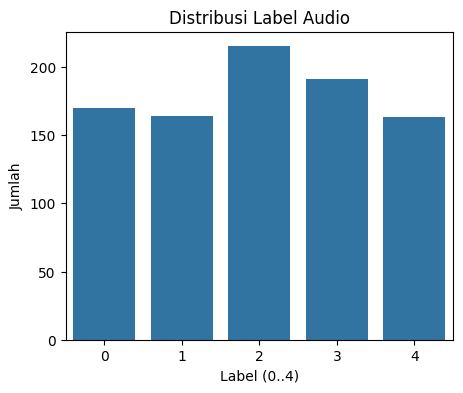

In [ ]:
import seaborn as sns
plt.figure(figsize=(5,4))
sns.countplot(x="label_idx", data=df_audio)
plt.title("Distribusi Label Audio")
plt.xlabel("Label (0..4)")
plt.ylabel("Jumlah")
plt.show()


Sample audio: /content/dataset_mirex/dataset/Audio/001.mp3


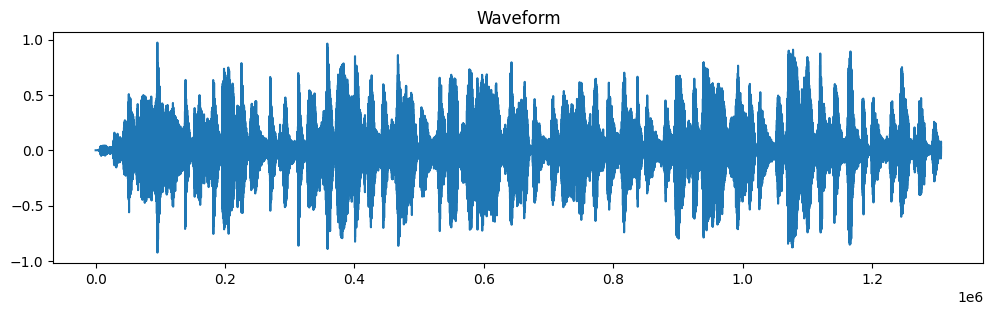

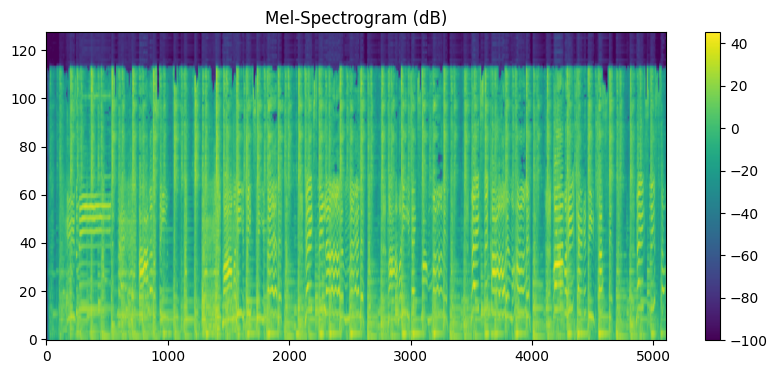

In [ ]:
!pip install torchcodec > /dev/null
import torchaudio  # reload setelah install

import torchaudio
import matplotlib.pyplot as plt

sample_path = df_audio["audio_path"].iloc[0]
print("Sample audio:", sample_path)

wav, sr = torchaudio.load(sample_path)
wav = wav.mean(dim=0, keepdim=True)  # mono

mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=22050, n_fft=1024, hop_length=256, n_mels=128
)
amp_to_db = torchaudio.transforms.AmplitudeToDB()

mel = mel_transform(wav)
mel_db = amp_to_db(mel)

plt.figure(figsize=(12,3))
plt.plot(wav[0].numpy())
plt.title("Waveform")
plt.show()

plt.figure(figsize=(10,4))
plt.imshow(mel_db[0].numpy(), aspect="auto", origin="lower")
plt.title("Mel-Spectrogram (dB)")
plt.colorbar()
plt.show()


In [ ]:
train_df = df_audio[df_audio["split"]=="train"].reset_index(drop=True)
val_df   = df_audio[df_audio["split"]=="val"].reset_index(drop=True)
test_df  = df_audio[df_audio["split"]=="test"].reset_index(drop=True)

train_df["label"] = train_df["label_idx"].astype(int)
val_df["label"]   = val_df["label_idx"].astype(int)
test_df["label"]  = test_df["label_idx"].astype(int)

print(len(train_df), len(val_df), len(test_df))


722 90 91


In [ ]:
from torch.utils.data import Dataset
import torch.nn.functional as F
import random

SAMPLE_RATE = 22050
N_MELS = 128
TARGET_FRAMES = 1024  # boleh diganti 512/1536 kalau mau, tapi 1024 aman

mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE, n_fft=1024, hop_length=256, n_mels=N_MELS
)
amp_to_db = torchaudio.transforms.AmplitudeToDB()

class AudioDataset(Dataset):
    def __init__(self, df, split: str, target_frames: int = TARGET_FRAMES):
        self.paths = df["audio_path"].tolist()
        self.labels = df["label"].tolist()
        self.split = split  # "train" / "val" / "test"
        self.target_frames = target_frames

    def __len__(self):
        return len(self.paths)

    def _crop_or_pad(self, mel_db):
        """
        mel_db: (1, n_mels, T)
        return: (1, n_mels, target_frames)
        """
        _, _, T = mel_db.shape
        if T == self.target_frames:
            return mel_db

        if T > self.target_frames:
            # crop
            if self.split == "train":
                # random crop
                start = random.randint(0, T - self.target_frames)
            else:
                # center crop untuk val/test
                start = max(0, (T - self.target_frames) // 2)
            mel_db = mel_db[:, :, start:start + self.target_frames]
        else:
            # pad di kanan
            pad_len = self.target_frames - T
            # pad = (pad_left, pad_right) utk dim terakhir
            mel_db = F.pad(mel_db, (0, pad_len))

        return mel_db

    def __getitem__(self, idx):
        path = str(self.paths[idx])
        label = self.labels[idx]

        wav, sr = torchaudio.load(path)

        if wav.shape[0] > 1:
            wav = wav.mean(dim=0, keepdim=True)

        wav = torchaudio.functional.resample(wav, sr, SAMPLE_RATE)

        mel = mel_transform(wav)
        mel_db = amp_to_db(mel)  # (1, n_mels, T)

        mel_db = self._crop_or_pad(mel_db)  # (1, n_mels, TARGET_FRAMES)

        return mel_db, torch.tensor(label)


In [ ]:
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np

NUM_CLASSES = 5

# ========== HITUNG SAMPLER WEIGHT ==========
labels_train = train_df["label"].values
class_counts = np.bincount(labels_train, minlength=NUM_CLASSES)

print("Class counts:", class_counts)

class_weights = 1.0 / (class_counts + 1e-6)
sample_weights = class_weights[labels_train]

sampler = WeightedRandomSampler(
    sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# ========== DATASET BARU DENGAN SPLIT ==========
train_dataset = AudioDataset(train_df, split="train")
val_dataset   = AudioDataset(val_df,   split="val")
test_dataset  = AudioDataset(test_df,  split="test")

# ========== DATALOADER ==========
train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler)
val_loader   = DataLoader(val_dataset,   batch_size=8, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=8, shuffle=False)


Class counts: [136 131 172 153 130]


In [ ]:
import torch.nn as nn

class CRNN(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,2))
        )

        self.gru = nn.GRU(
            input_size=64,
            hidden_size=128,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Linear(128*2, num_classes)

    def forward(self, x):
        x = self.cnn(x)          # (B, 64, mel/4, time/4)
        x = x.permute(0,3,1,2)   # (B, time, channel, mel)
        x = x.mean(dim=-1)
        out,_ = self.gru(x)
        out = out[:, -1, :]
        return self.fc(out)


In [ ]:
model = CRNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

from transformers import get_linear_schedule_with_warmup

num_training_steps = len(train_loader) * 20

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps
)


In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
from transformers import get_linear_schedule_with_warmup

# ============ SEED ============
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ============ MODEL ============
model = CRNN(num_classes=NUM_CLASSES).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 20
patience = 5

num_training_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps
)

print("num_training_steps:", num_training_steps)


Device: cuda
num_training_steps: 1820


In [ ]:
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score
)
from tqdm.auto import tqdm

best_val_f1 = 0.0
patience_counter = 0

history = {
    "epoch": [],
    "lr": [],
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
    "train_f1": [],
    "val_f1": [],
    "train_prec": [],
    "val_prec": [],
    "train_rec": [],
    "val_rec": [],
}

for epoch in range(EPOCHS):
    print(f"\n=== Epoch {epoch+1}/{EPOCHS} ===")

    # ------------- TRAIN -------------
    model.train()
    total_loss = 0.0
    all_train_preds = []
    all_train_labels = []

    for mel_db, labels in tqdm(train_loader, desc=f"Train {epoch+1}"):
        mel_db = mel_db.to(device)
        labels = labels.to(device)

        outputs = model(mel_db)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_train_preds.extend(preds.detach().cpu().numpy())
        all_train_labels.extend(labels.detach().cpu().numpy())

    avg_train_loss = total_loss / len(train_loader)
    train_acc  = accuracy_score(all_train_labels, all_train_preds)
    train_f1   = f1_score(all_train_labels, all_train_preds, average="macro")
    train_prec = precision_score(all_train_labels, all_train_preds, average="macro", zero_division=0)
    train_rec  = recall_score(all_train_labels, all_train_preds, average="macro", zero_division=0)
    current_lr = scheduler.get_last_lr()[0]

    print(f"Train loss : {avg_train_loss:.4f} | "
          f"acc: {train_acc:.4f} | "
          f"F1: {train_f1:.4f} | "
          f"prec: {train_prec:.4f} | "
          f"rec: {train_rec:.4f} | "
          f"lr: {current_lr:.6f}")

    # ------------- VALIDATION -------------
    model.eval()
    val_loss = 0.0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for mel_db, labels in tqdm(val_loader, desc="Val"):
            mel_db = mel_db.to(device)
            labels = labels.to(device)

            outputs = model(mel_db)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_val_preds.extend(preds.detach().cpu().numpy())
            all_val_labels.extend(labels.detach().cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc  = accuracy_score(all_val_labels, all_val_preds)
    val_f1   = f1_score(all_val_labels, all_val_preds, average="macro")
    val_prec = precision_score(all_val_labels, all_val_preds, average="macro", zero_division=0)
    val_rec  = recall_score(all_val_labels, all_val_preds, average="macro", zero_division=0)

    print(f"Val   loss : {avg_val_loss:.4f} | "
          f"acc: {val_acc:.4f} | "
          f"F1: {val_f1:.4f} | "
          f"prec: {val_prec:.4f} | "
          f"rec: {val_rec:.4f}")

    # simpan history
    history["epoch"].append(epoch+1)
    history["lr"].append(current_lr)
    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(avg_val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["train_f1"].append(train_f1)
    history["val_f1"].append(val_f1)
    history["train_prec"].append(train_prec)
    history["val_prec"].append(val_prec)
    history["train_rec"].append(train_rec)
    history["val_rec"].append(val_rec)

    # ------------- EARLY STOPPING -------------
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0
        torch.save(model.state_dict(), DATASET_ROOT / "best_audio_crnn.pt")
        print(f"✅ Model improved (val F1={val_f1:.4f}), saved.")
    else:
        patience_counter += 1
        print(f"No improvement, patience {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("⏹ Early stopping.")
            break



=== Epoch 1/20 ===


Train 1:   0%|          | 0/91 [00:00<?, ?it/s]

Train loss : 1.6214 | acc: 0.1911 | F1: 0.0824 | prec: 0.1235 | rec: 0.1987 | lr: 0.000050


Val:   0%|          | 0/12 [00:00<?, ?it/s]

Val   loss : 1.6089 | acc: 0.2333 | F1: 0.1765 | prec: 0.1635 | rec: 0.2219
✅ Model improved (val F1=0.1765), saved.

=== Epoch 2/20 ===


Train 2:   0%|          | 0/91 [00:00<?, ?it/s]

Train loss : 1.5914 | acc: 0.2618 | F1: 0.2097 | prec: 0.1998 | rec: 0.2543 | lr: 0.000100


Val:   0%|          | 0/12 [00:00<?, ?it/s]

Val   loss : 1.5692 | acc: 0.3333 | F1: 0.2413 | prec: 0.2166 | rec: 0.3059
✅ Model improved (val F1=0.2413), saved.

=== Epoch 3/20 ===


Train 3:   0%|          | 0/91 [00:00<?, ?it/s]

Train loss : 1.5849 | acc: 0.2673 | F1: 0.2056 | prec: 0.2425 | rec: 0.2544 | lr: 0.000094


Val:   0%|          | 0/12 [00:00<?, ?it/s]

Val   loss : 1.5710 | acc: 0.3667 | F1: 0.2668 | prec: 0.2311 | rec: 0.3672
✅ Model improved (val F1=0.2668), saved.

=== Epoch 4/20 ===


Train 4:   0%|          | 0/91 [00:00<?, ?it/s]

Train loss : 1.5837 | acc: 0.2673 | F1: 0.2354 | prec: 0.2601 | rec: 0.2639 | lr: 0.000089


Val:   0%|          | 0/12 [00:00<?, ?it/s]

Val   loss : 1.5482 | acc: 0.3222 | F1: 0.2688 | prec: 0.3317 | rec: 0.3026
✅ Model improved (val F1=0.2688), saved.

=== Epoch 5/20 ===


Train 5:   0%|          | 0/91 [00:00<?, ?it/s]

Train loss : 1.5901 | acc: 0.2590 | F1: 0.2199 | prec: 0.2135 | rec: 0.2548 | lr: 0.000083


Val:   0%|          | 0/12 [00:00<?, ?it/s]

Val   loss : 1.5552 | acc: 0.3889 | F1: 0.2907 | prec: 0.2404 | rec: 0.3863
✅ Model improved (val F1=0.2907), saved.

=== Epoch 6/20 ===


Train 6:   0%|          | 0/91 [00:00<?, ?it/s]

Train loss : 1.5885 | acc: 0.2576 | F1: 0.1944 | prec: 0.1894 | rec: 0.2452 | lr: 0.000078


Val:   0%|          | 0/12 [00:00<?, ?it/s]

Val   loss : 1.5479 | acc: 0.3556 | F1: 0.2737 | prec: 0.4633 | rec: 0.3344
No improvement, patience 1/5

=== Epoch 7/20 ===


Train 7:   0%|          | 0/91 [00:00<?, ?it/s]

Train loss : 1.5793 | acc: 0.2729 | F1: 0.2528 | prec: 0.2929 | rec: 0.2700 | lr: 0.000072


Val:   0%|          | 0/12 [00:00<?, ?it/s]

Val   loss : 1.5408 | acc: 0.3889 | F1: 0.3290 | prec: 0.3692 | rec: 0.3749
✅ Model improved (val F1=0.3290), saved.

=== Epoch 8/20 ===


Train 8:   0%|          | 0/91 [00:00<?, ?it/s]

Train loss : 1.5643 | acc: 0.2798 | F1: 0.2488 | prec: 0.2554 | rec: 0.2840 | lr: 0.000067


Val:   0%|          | 0/12 [00:00<?, ?it/s]

Val   loss : 1.5513 | acc: 0.3444 | F1: 0.2850 | prec: 0.2903 | rec: 0.3231
No improvement, patience 1/5

=== Epoch 9/20 ===


Train 9:   0%|          | 0/91 [00:00<?, ?it/s]

Train loss : 1.5888 | acc: 0.2729 | F1: 0.2476 | prec: 0.2661 | rec: 0.2730 | lr: 0.000061


Val:   0%|          | 0/12 [00:00<?, ?it/s]

Val   loss : 1.5434 | acc: 0.3000 | F1: 0.2521 | prec: 0.6296 | rec: 0.2925
No improvement, patience 2/5

=== Epoch 10/20 ===


Train 10:   0%|          | 0/91 [00:00<?, ?it/s]

Train loss : 1.5730 | acc: 0.2922 | F1: 0.2477 | prec: 0.3253 | rec: 0.2829 | lr: 0.000056


Val:   0%|          | 0/12 [00:00<?, ?it/s]

Val   loss : 1.5229 | acc: 0.4111 | F1: 0.3562 | prec: 0.4180 | rec: 0.3964
✅ Model improved (val F1=0.3562), saved.

=== Epoch 11/20 ===


Train 11:   0%|          | 0/91 [00:00<?, ?it/s]

Train loss : 1.5616 | acc: 0.2978 | F1: 0.2476 | prec: 0.2575 | rec: 0.2945 | lr: 0.000050


Val:   0%|          | 0/12 [00:00<?, ?it/s]

Val   loss : 1.5219 | acc: 0.4000 | F1: 0.3127 | prec: 0.3136 | rec: 0.3921
No improvement, patience 1/5

=== Epoch 12/20 ===


Train 12:   0%|          | 0/91 [00:00<?, ?it/s]

Train loss : 1.5657 | acc: 0.2867 | F1: 0.2331 | prec: 0.2595 | rec: 0.2873 | lr: 0.000044


Val:   0%|          | 0/12 [00:00<?, ?it/s]

Val   loss : 1.5156 | acc: 0.3778 | F1: 0.3030 | prec: 0.4094 | rec: 0.3641
No improvement, patience 2/5

=== Epoch 13/20 ===


Train 13:   0%|          | 0/91 [00:00<?, ?it/s]

Train loss : 1.5642 | acc: 0.2950 | F1: 0.2709 | prec: 0.2802 | rec: 0.2980 | lr: 0.000039


Val:   0%|          | 0/12 [00:00<?, ?it/s]

Val   loss : 1.5147 | acc: 0.3333 | F1: 0.2823 | prec: 0.2631 | rec: 0.3208
No improvement, patience 3/5

=== Epoch 14/20 ===


Train 14:   0%|          | 0/91 [00:00<?, ?it/s]

Train loss : 1.5624 | acc: 0.3089 | F1: 0.2888 | prec: 0.2973 | rec: 0.3060 | lr: 0.000033


Val:   0%|          | 0/12 [00:00<?, ?it/s]

Val   loss : 1.5057 | acc: 0.3556 | F1: 0.2944 | prec: 0.3072 | rec: 0.3468
No improvement, patience 4/5

=== Epoch 15/20 ===


Train 15:   0%|          | 0/91 [00:00<?, ?it/s]

Train loss : 1.5667 | acc: 0.2798 | F1: 0.2396 | prec: 0.2512 | rec: 0.2797 | lr: 0.000028


Val:   0%|          | 0/12 [00:00<?, ?it/s]

Val   loss : 1.5001 | acc: 0.3778 | F1: 0.2976 | prec: 0.3832 | rec: 0.3631
No improvement, patience 5/5
⏹ Early stopping.


In [ ]:
best_audio_path = SAVE_DIR / "best_audio_crnn.pt"
torch.save(model.state_dict(), best_audio_path)
print("✅ Best audio CRNN disimpan di:", best_audio_path)

✅ History training audio disimpan di: /content/drive/MyDrive/dataset_mirex/miditrainX/audio_training_history.csv


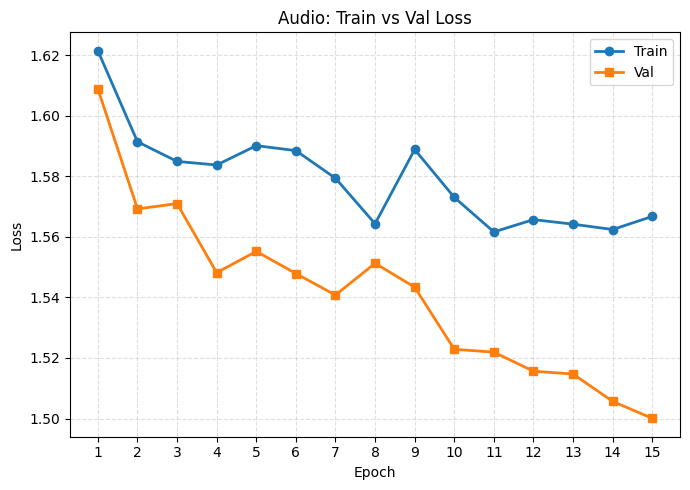

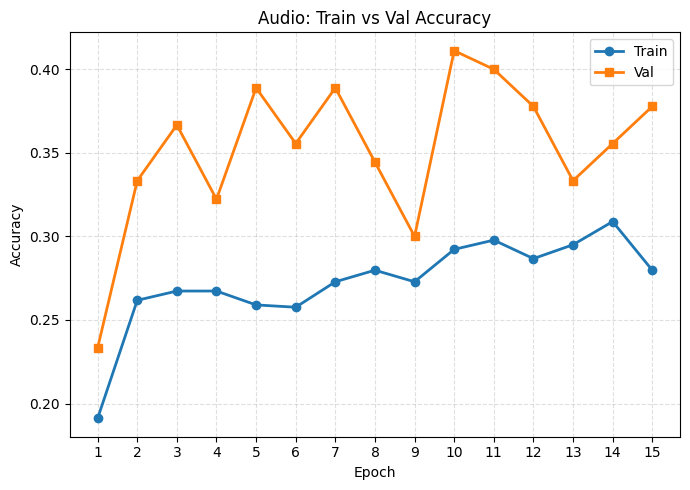

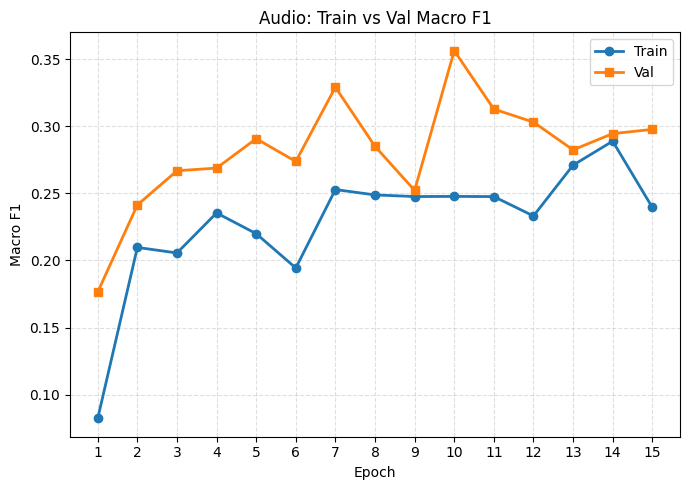

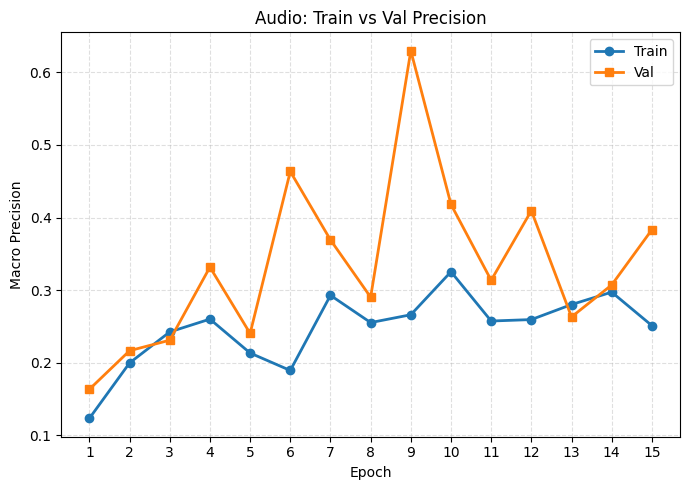

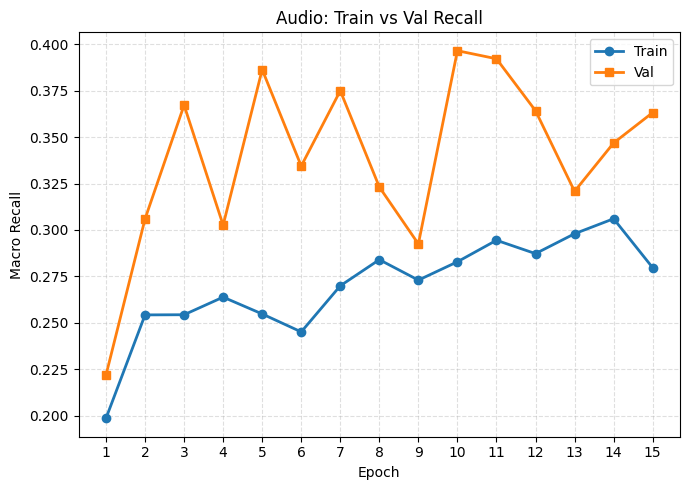

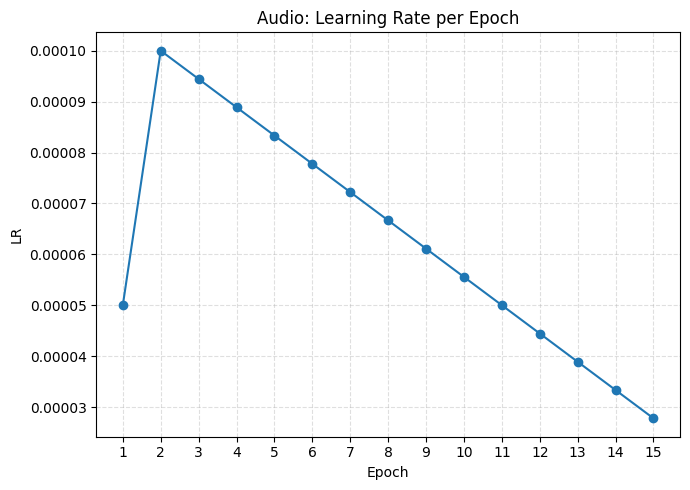

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# simpan history ke CSV kalau mau
history_df = pd.DataFrame(history)
history_csv_path = SAVE_DIR / "audio_training_history.csv"
history_df.to_csv(history_csv_path, index=False)
print("✅ History training audio disimpan di:", history_csv_path)

def plot_compare(train_values, val_values, title, ylabel):
    plt.figure(figsize=(7,5))
    epochs = np.arange(1, len(train_values)+1)
    plt.plot(epochs, train_values, marker='o', label='Train', linewidth=2)
    plt.plot(epochs, val_values, marker='s', label='Val', linewidth=2)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.xticks(epochs)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_compare(history["train_loss"], history["val_loss"],
             "Audio: Train vs Val Loss", "Loss")

plot_compare(history["train_acc"], history["val_acc"],
             "Audio: Train vs Val Accuracy", "Accuracy")

plot_compare(history["train_f1"], history["val_f1"],
             "Audio: Train vs Val Macro F1", "Macro F1")

plot_compare(history["train_prec"], history["val_prec"],
             "Audio: Train vs Val Precision", "Macro Precision")

plot_compare(history["train_rec"], history["val_rec"],
             "Audio: Train vs Val Recall", "Macro Recall")

plt.figure(figsize=(7,5))
epochs = np.arange(1, len(history["lr"])+1)
plt.plot(epochs, history["lr"], marker='o')
plt.title("Audio: Learning Rate per Epoch")
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.grid(True, linestyle='--', alpha=0.4)
plt.xticks(epochs)
plt.tight_layout()
plt.show()


Test:   0%|          | 0/12 [00:00<?, ?it/s]

🎧 Audio Test Accuracy: 0.25274725274725274
🎧 Audio Test Macro F1: 0.23468642752530222
              precision    recall  f1-score   support

           0      0.167     0.059     0.087        17
           1      0.227     0.294     0.256        17
           2      0.241     0.318     0.275        22
           3      0.375     0.158     0.222        19
           4      0.269     0.438     0.333        16

    accuracy                          0.253        91
   macro avg      0.256     0.253     0.235        91
weighted avg      0.258     0.253     0.236        91

Confusion matrix:
 [[1 2 5 1 8]
 [2 5 8 0 2]
 [0 7 7 2 6]
 [2 4 7 3 3]
 [1 4 2 2 7]]


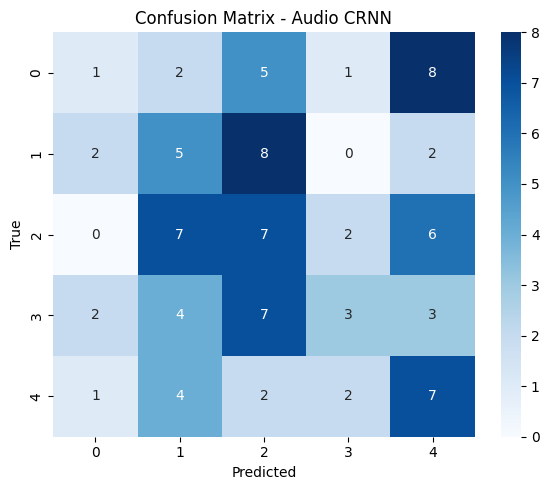

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# load best model
best_model_path = DATASET_ROOT / "best_audio_crnn.pt"
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

all_test_labels = []
all_test_preds  = []
all_test_probs  = []
all_test_ids    = test_df["file_id_norm"].tolist()  # pakai id konsisten

with torch.no_grad():
    for mel_db, labels in tqdm(test_loader, desc="Test"):
        mel_db = mel_db.to(device)
        labels = labels.to(device)

        outputs = model(mel_db)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(preds.cpu().numpy())
        all_test_probs.extend(probs.cpu().numpy())

acc = accuracy_score(all_test_labels, all_test_preds)
f1  = f1_score(all_test_labels, all_test_preds, average="macro")
print("🎧 Audio Test Accuracy:", acc)
print("🎧 Audio Test Macro F1:", f1)
print(classification_report(all_test_labels, all_test_preds, digits=3))

cm = confusion_matrix(all_test_labels, all_test_preds)
print("Confusion matrix:\n", cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0,1,2,3,4],
            yticklabels=[0,1,2,3,4])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Audio CRNN")
plt.tight_layout()
plt.show()


In [ ]:
probs_array = np.array(all_test_probs)

# CSV probabilitas untuk fusion
audio_prob_df = pd.DataFrame({
    "id": all_test_ids,
    "true_label": all_test_labels,
})
for i in range(NUM_CLASSES):
    audio_prob_df[f"prob_cluster_{i+1}"] = probs_array[:, i]

audio_prob_path = SAVE_DIR / "audio_prob_for_fusion.csv"
audio_prob_df.to_csv(audio_prob_path, index=False)
print("✅ audio_prob_for_fusion.csv disimpan di:", audio_prob_path)

# CSV hasil unimodal
audio_unimodal_df = pd.DataFrame({
    "id": all_test_ids,
    "true_label": all_test_labels,
    "pred_label": all_test_preds,
})
for i in range(NUM_CLASSES):
    audio_unimodal_df[f"prob_cluster_{i+1}"] = probs_array[:, i]

audio_unimodal_path = SAVE_DIR / "audio_unimodal_test_results.csv"
audio_unimodal_df.to_csv(audio_unimodal_path, index=False)
print("✅ audio_unimodal_test_results.csv disimpan di:", audio_unimodal_path)


✅ audio_prob_for_fusion.csv disimpan di: /content/drive/MyDrive/dataset_mirex/miditrainX/audio_prob_for_fusion.csv
✅ audio_unimodal_test_results.csv disimpan di: /content/drive/MyDrive/dataset_mirex/miditrainX/audio_unimodal_test_results.csv
